# Воложанин В.О. ИВТ 1.3 ЛР №1 
### Задача предсказания оттока клиентов банка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Проверка пропущенных значений и проверка пропущенных значений

In [3]:
churn_data = pd.read_csv('churn.csv')

missing_values = churn_data.isnull().sum()
missing_values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Визуализация классов

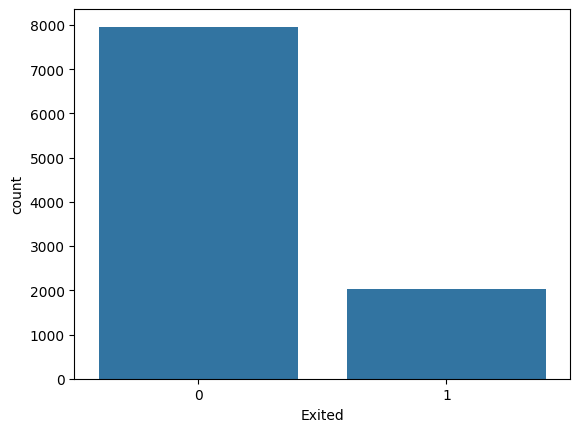

In [4]:
sns.countplot(x='Exited', data=churn_data)
plt.show()

### Определение категориальных признаков

In [5]:
categorical_features = churn_data.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Surname', 'Geography', 'Gender']

In [6]:
churn_data_processed = churn_data.copy()

columns_to_remove = ['Surname', 'RowNumber', 'CustomerId']
churn_data_processed.drop(columns=[col for col in columns_to_remove if col in churn_data_processed], axis=1, inplace=True)

for feature in categorical_features:
    if feature in churn_data_processed.columns:
        print(f"Уникальные значения {feature}: {churn_data_processed[feature].unique()}")

Уникальные значения Geography: ['France' 'Spain' 'Germany']
Уникальные значения Gender: ['Female' 'Male']


### Преобразование в dummy переменные

In [7]:
churn_data_dummies = pd.get_dummies(churn_data_processed, drop_first=True)
churn_data_dummies.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


### Создание матрицы признаков X

In [8]:
X_features = churn_data_dummies.drop('Exited', axis=1)
y_target = churn_data_dummies['Exited']

### Разделение данных на тренировочную и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, stratify=y_target, random_state=1)

### Нормализация данных

In [10]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Инициализация и обучение модели

In [11]:
logistic_model = LogisticRegression(solver='sag', random_state=1, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

### Предсказание значений и  вывод метрик

In [12]:
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

print("Отчет по метрикам для тренировочной выборки:")
print(classification_report(y_train, y_train_pred))
print('---------------------------')
print("Отчет по метрикам для тестовой выборки:")
print(classification_report(y_test, y_test_pred))

Отчет по метрикам для тренировочной выборки:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6370
           1       0.62      0.20      0.31      1630

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.60      8000
weighted avg       0.78      0.81      0.77      8000

---------------------------
Отчет по метрикам для тестовой выборки:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.61      0.19      0.29       407

    accuracy                           0.81      2000
   macro avg       0.72      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



### Предсказание вероятностей, инициализация списков и вычисление метрик

In [13]:
y_test_probabilities = logistic_model.predict_proba(X_test_scaled)[:, 1]

recall_scores = []
precision_scores = []
f1_scores = []
threshold_values = np.arange(0.1, 1, 0.05)

for threshold in threshold_values:
    y_test_threshold = (y_test_probabilities > threshold).astype(int)
    recall_scores.append(recall_score(y_test, y_test_threshold))
    precision_scores.append(precision_score(y_test, y_test_threshold))
    f1_scores.append(f1_score(y_test, y_test_threshold))

/opt/homebrew/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Визуализация зависимости метрик

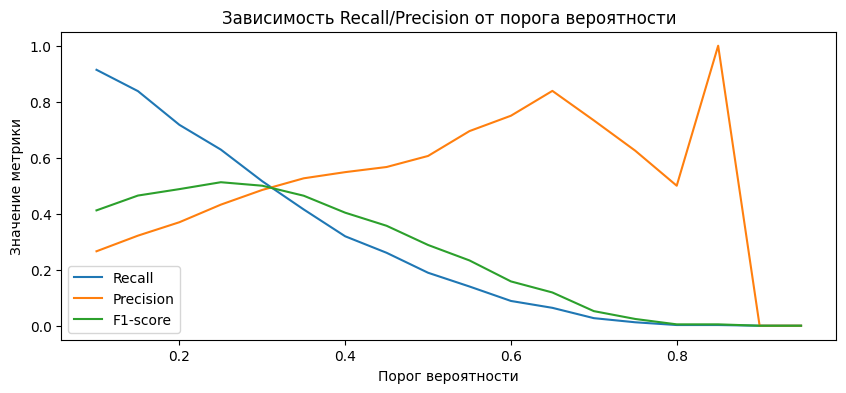

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(threshold_values, recall_scores, label='Recall')
plt.plot(threshold_values, precision_scores, label='Precision')
plt.plot(threshold_values, f1_scores, label='F1-score')
plt.title('Зависимость Recall/Precision от порога вероятности')
plt.xlabel('Порог вероятности')
plt.ylabel('Значение метрики')
plt.legend()
plt.show()

### Вывод итогового отчета по метрикам 

In [15]:
optimal_threshold = 0.3
y_test_optimal = (y_test_probabilities > optimal_threshold).astype(int)

print("Итоговый отчет по метрикам для тестовой выборки:")
print(classification_report(y_test, y_test_optimal))

Итоговый отчет по метрикам для тестовой выборки:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1593
           1       0.48      0.52      0.50       407

    accuracy                           0.79      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.80      0.79      0.79      2000

